# Bat Orientaion Calls - Classification with CNN



## General Preparations

Getting started with tensorflow on Mac M1:
https://github.com/jeffheaton/t81_558_deep_learning/blob/master/install/tensorflow-install-mac-metal-jul-2021.ipynb

activate environment
`conda activate apple_tensorflow`

deactivate  environment
`conda deactivate`

start jupyter
`jupyter notebook`

In [1]:
from matplotlib import image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pathlib
import glob
import shutil
import os
import cv2
import sys
import tensorflow as tf
import itertools
import math
import visualkeras

from keras.utils.vis_utils import plot_model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import keras_tuner as kt

In [2]:
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tf.keras.__version__}")
print(f"Keras Tuner Version: {kt.__version__}")
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.9.2
Keras Version: 2.9.0
Keras Tuner Version: 1.1.2
Python 3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:00:33) 
[Clang 13.0.1 ]
Pandas 1.4.2
Scikit-Learn 1.1.1
GPU is available


We have to reanrage the given data to a new folder structure to use `image_dataset_from_directory`:

- images
   - class1
        - *.png
   - class2
        - *.png
   ...
   
and crop the x-Axis and y-Axis from the images.

In [4]:
df = pd.read_csv("data.csv", header=0, delimiter=';')
#shutil.unpack_archive("2_LMU_20180326_png.zip", "images")

counter = 0
for index, row in df.iterrows():
    folder = row['Species']
    filename = row['Filename'].replace('.jpg', '.png')
    
    if not os.path.exists(f'images_sorted/{folder}'):
        os.makedirs(f'images_sorted/{folder}')
    
    if os.path.exists(f'images/{filename}'):
        img = cv2.imread(f'images/{filename}')
        crop_img = img[36:252, 55:389]
        cv2.imwrite(f'images_sorted/{folder}/{filename}', crop_img)
    else:
        counter += 1

In [5]:
print(f"DF Size: {len(df.index)}")
print(f"Images not found: {counter}")

DF Size: 4310
Images not found: 1


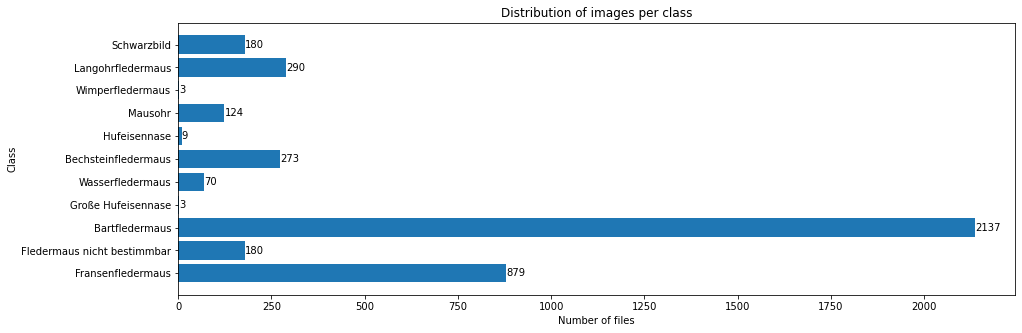

In [6]:
names=[]
length=[]

for path in glob.glob('images_sorted/*/'):
    names.append(path.split("/")[1])
    length.append(len(glob.glob(f'{path}*.png'))) 
 
fig, ax = plt.subplots(figsize = (15, 5))
bars = ax.barh(names, length)

ax.bar_label(bars)
     
plt.xlabel("Number of files")
plt.ylabel("Class")
plt.title("Distribution of images per class")
plt.show()

fig.savefig(f'plots/image_dist', dpi=600)

In [7]:
shutil.rmtree("images_sorted/Wimperfledermaus")
shutil.rmtree("images_sorted/Hufeisennase")
shutil.rmtree("images_sorted/Große Hufeisennase")
shutil.rmtree("images_sorted/Fledermaus nicht bestimmbar")

## Global Functions for Plots

In [8]:
def plot_confusion_matrix(cm, classes):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,10), sharex=True, sharey=True)
    
    ax1.title.set_text('Absolut')
    ax2.title.set_text('Relative')
    fig.text(0.5, 0, 'Predicated Label', ha='center')
    fig.text(0, 0.5, 'True label', va='center', rotation='vertical')

    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      
    sns.heatmap(cm, annot=True, xticklabels=classes, yticklabels=classes, ax=ax1, cmap="YlGnBu")
    sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes, ax=ax2, cmap="YlGnBu")
    
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()

In [9]:
def plot_model_loss_acc(epochs_range, acc, val_acc, loss, val_loss):
    plt.figure(figsize=(15, 10))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', marker='o')
    plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.savefig('loss_plot.png')
    plt.show()
    

## Data Preparation

In [38]:
data_dir = pathlib.Path("images_sorted")
image_count = len(list(data_dir.glob('*/*.png')))
print(f"Found {image_count} images")

Found 3953 images


In [39]:
bat_filename = df["Filename"][0]
bat_species = df["Species"][0]
bat_image = image.imread(f'images_sorted/{bat_species}/{bat_filename.replace(".jpg", ".png")}')
img_height, img_width, img_channels = bat_image.shape
batch_size = 64
print(f"Bat image shape: {bat_image.shape}")

Bat image shape: (216, 334, 3)


Create training and validation data sets with keras `image_dataset_from_directory`. We are using 80% for training and 20% for validation.

In [40]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  label_mode='categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  label_mode='categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3953 files belonging to 7 classes.
Using 3163 files for training.
Found 3953 files belonging to 7 classes.
Using 790 files for validation.


We can access the different `class_names` of the data set:

In [41]:
class_names = train_ds.class_names
print(class_names)

['Bartfledermaus', 'Bechsteinfledermaus', 'Fransenfledermaus', 'Langohrfledermaus', 'Mausohr', 'Schwarzbild', 'Wasserfledermaus']


## Overview

### Plot

2022-07-02 12:25:41.933107: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


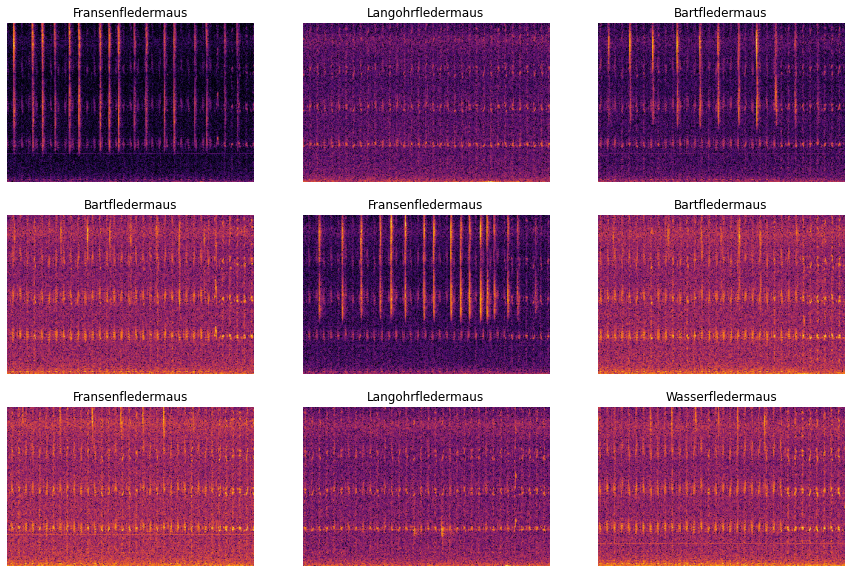

In [14]:
plt.figure(figsize=(15, 10))
for images, labels in train_ds.take(1):

  for i in range(9):
    index = tf.argmax(labels[i], axis=0)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[index.numpy()])
    plt.axis("off")

### Input shape

In [15]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 216, 334, 3)
(64, 7)


## Models

### Preparations

Configure the dataset for performance, see: https://www.tensorflow.org/tutorials/images/classification#configure_the_dataset_for_performance

In [42]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

The RGB channel values are in the [0, 255] range. 
Here, we will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling:

In [43]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

An example:
(Later we will use the Rescaling directly in our model.)

In [44]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.98823535


### First Simple Model

In [19]:
model = keras.Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32,                      
                  kernel_size=(3,3),         
                  strides=(1,1),            
                  padding='same',            
                  activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Conv2D(64,                      
                  kernel_size=(3,3),         
                  strides=(1,1),            
                  padding='same',            
                  activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Conv2D(128,                      
                  kernel_size=(3,3),         
                  strides=(1,1),            
                  padding='same',            
                  activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Flatten(),
    
  layers.Dropout(0.05),
    
  layers.Dense(160, 
               kernel_regularizer=keras.regularizers.l2(0.001), 
               bias_regularizer=keras.regularizers.l2(0.001), 
               activation='relu'),
  
  layers.Dense(len(class_names), activation='softmax')
])

In [20]:
adamOptimizer=keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)


model.compile(optimizer=adamOptimizer,
      loss='categorical_crossentropy',
      metrics=['accuracy'])

Before we fit our model, we add twoi more things: **early stopping** and a **scheduler** for the **learning rate**.

Early stopping:

In [21]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

Scheduler for dynamic learning rate:

In [22]:
start_lr = 0.0001
exp_decay = 0.1

def scheduler(epoch):
    return start_lr * math.exp(-exp_decay*epoch)

scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 216, 334, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 216, 334, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 108, 167, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 167, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 83, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 54, 83, 128)       7

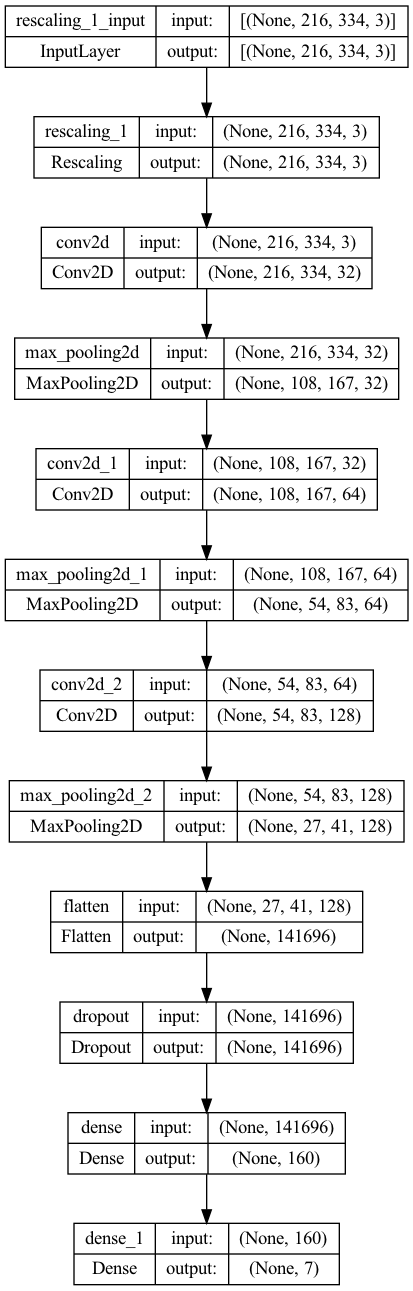

In [24]:
visualkeras.layered_view(model, legend=True)
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Fit the model:

In [25]:
epochs=40
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[stop_early, scheduler]
)

Epoch 1/40


2022-07-02 12:26:15.987260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 1.6021 - accuracy: 0.5302

2022-07-02 12:26:35.765871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 22s 368ms/step - loss: 1.6021 - accuracy: 0.5302 - val_loss: 1.4177 - val_accuracy: 0.5544 - lr: 1.0000e-04
Epoch 2/40
50/50 [==============================] - 17s 349ms/step - loss: 1.3689 - accuracy: 0.5786 - val_loss: 1.3064 - val_accuracy: 0.5595 - lr: 9.0484e-05
Epoch 3/40
50/50 [==============================] - 18s 355ms/step - loss: 1.2392 - accuracy: 0.6371 - val_loss: 1.1783 - val_accuracy: 0.6278 - lr: 8.1873e-05
Epoch 4/40
50/50 [==============================] - 17s 349ms/step - loss: 1.0708 - accuracy: 0.6927 - val_loss: 1.0390 - val_accuracy: 0.7342 - lr: 7.4082e-05
Epoch 5/40
50/50 [==============================] - 17s 345ms/step - loss: 0.9396 - accuracy: 0.7404 - val_loss: 0.9839 - val_accuracy: 0.7392 - lr: 6.7032e-05
Epoch 6/40
50/50 [==============================] - 18s 352ms/step - loss: 0.8311 - accuracy: 0.7711 - val_loss: 0.9347 - val_accuracy: 0.7823 - lr: 6.0653e-05
Epoch 7/40
50/50 [==============================] -

In [26]:
model.evaluate(val_ds)

13/13 [==============================] - 2s 112ms/step - loss: 0.8604 - accuracy: 0.8000


[0.860431969165802, 0.800000011920929]

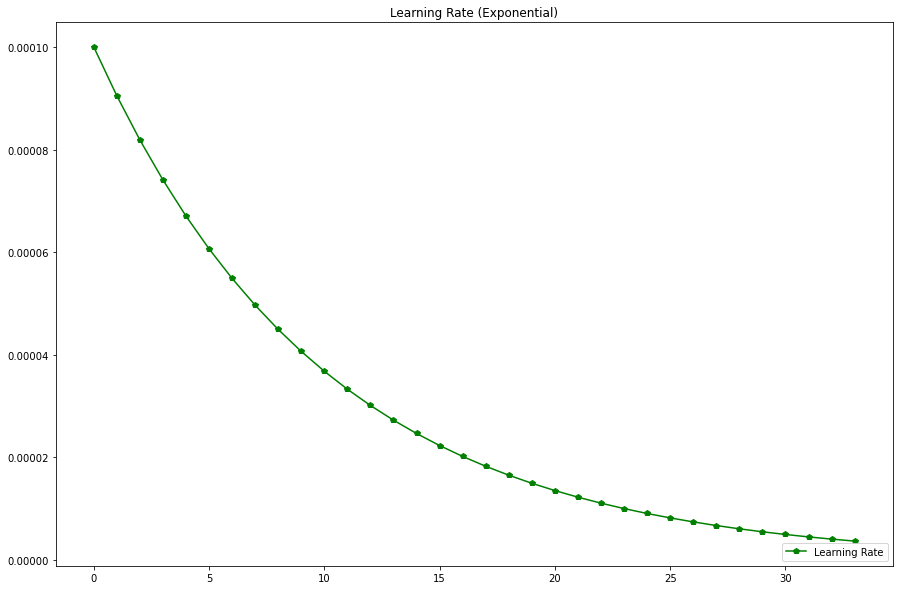

In [27]:
lr = history.history['lr']

plt.figure(figsize=(15, 10))
plt.plot(range(len(lr)), lr, label='Learning Rate', marker='p', color='g')
plt.legend(loc='lower right')
plt.title('Learning Rate (Exponential)')
plt.savefig('learning_rate.png')

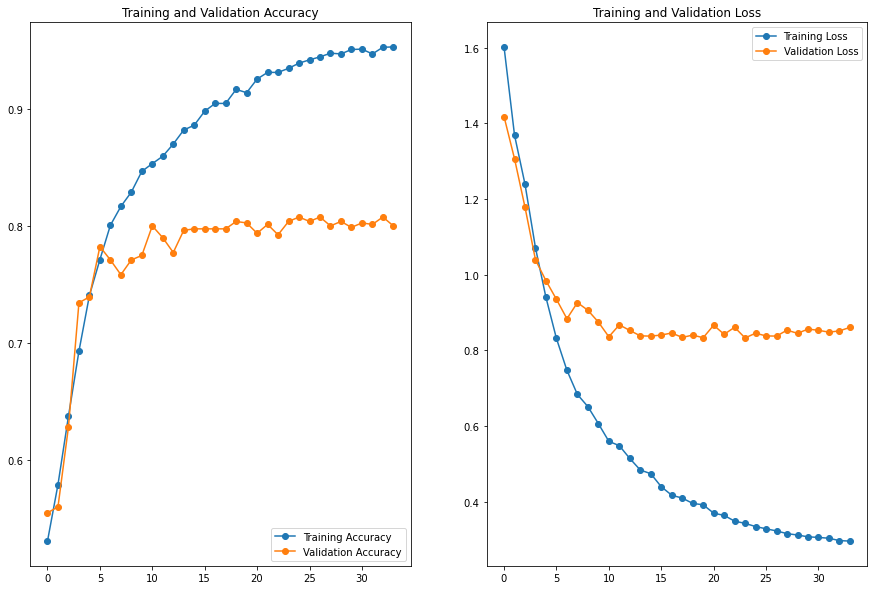

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Does not work because of early stopping
# epochs_range = range(epochs)
# Compute range of epochs out of model hsitory data

epochs_range = range(len(loss))

plot_model_loss_acc(epochs_range=epochs_range, acc=acc, val_acc=val_acc, loss=loss, val_loss=val_loss) 

 1/13 [=>............................] - ETA: 2s

2022-07-02 12:39:06.916197: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 2s 113ms/step


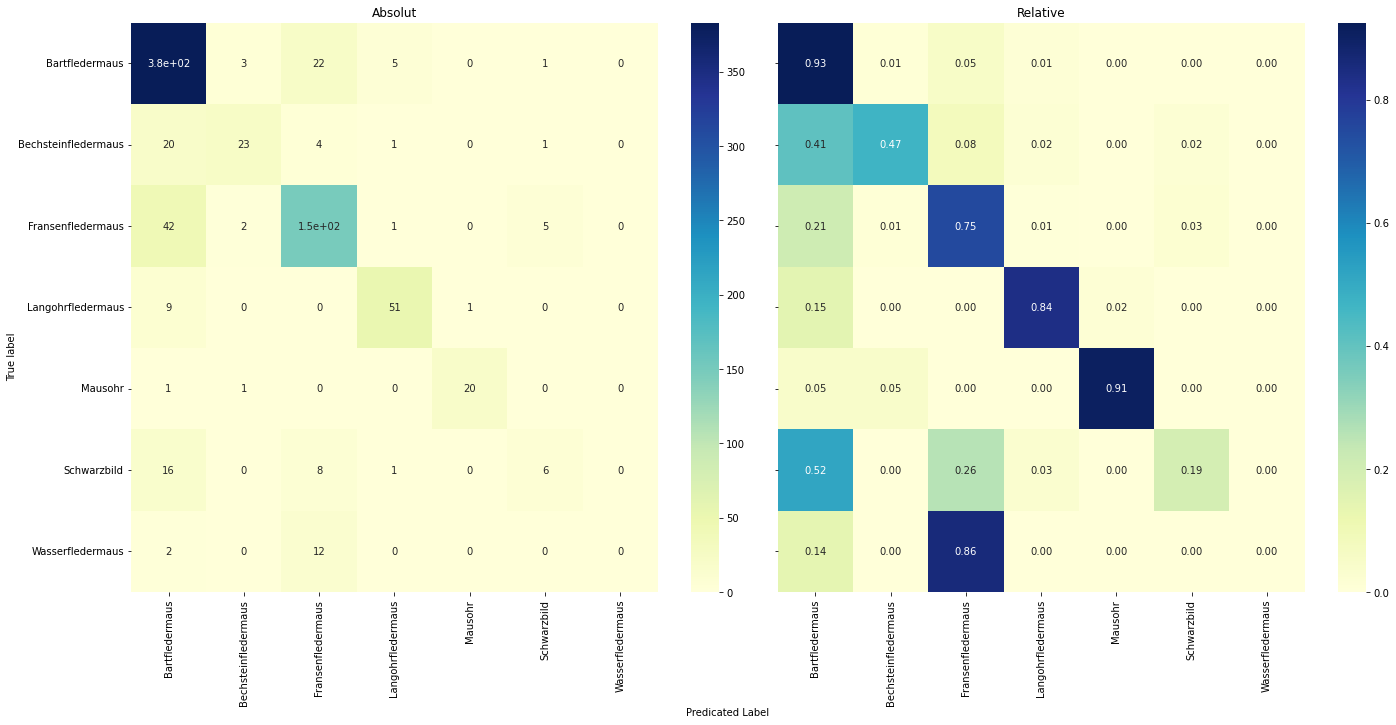

In [29]:
y_pred = model.predict(val_ds)
y_true = np.concatenate([y for x, y in val_ds], axis=0)

cm = confusion_matrix(y_true=np.argmax(y_true, axis=-1), y_pred=np.argmax(y_pred, axis=-1))
    
plot_confusion_matrix(cm=cm, classes=class_names)


### Enhancement with Data Augmentation

This was an attempt to generate more data and increase underrepresented classes. Model was poor, however. Too few epochs, poorly parameterized. Model needs to run much longer for reasonable learning.

In [45]:
with tf.device('/cpu:0'):
    data_augmentation = keras.Sequential(
      [
        layers.RandomFlip("horizontal",
                          input_shape=(img_height,
                                      img_width,
                                      3)),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
      ]
    )

model_da = keras.Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32,                      
                  kernel_size=(3,3),         
                  strides=(1,1),            
                  padding='same',            
                  activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Conv2D(64,                      
                  kernel_size=(3,3),         
                  strides=(1,1),            
                  padding='same',            
                  activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Conv2D(128,                      
                  kernel_size=(3,3),         
                  strides=(1,1),            
                  padding='same',            
                  activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Flatten(),
    
  layers.Dropout(0.05),
    
  layers.Dense(160, 
               kernel_regularizer=keras.regularizers.l2(0.001), 
               bias_regularizer=keras.regularizers.l2(0.001), 
               activation='relu'),
  
  layers.Dense(len(class_names), activation='softmax')
])

In [46]:
adamOptimizer=keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)

model_da.compile(optimizer=adamOptimizer,
      loss='categorical_crossentropy',
      metrics=['accuracy'])

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

start_lr = 0.0001
exp_decay = 0.1

def scheduler(epoch):
    return start_lr * math.exp(-exp_decay*epoch)

scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [47]:
model_da.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 216, 334, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 216, 334, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 108, 167, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 108, 167, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 54, 83, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 54, 83, 128)      

In [48]:
epochs=40
history_da = model_da.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[stop_early, scheduler]
)

Epoch 1/40


2022-07-02 13:15:11.579380: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 1.5542 - accuracy: 0.5286

2022-07-02 13:15:28.211830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 19s 345ms/step - loss: 1.5542 - accuracy: 0.5286 - val_loss: 1.3952 - val_accuracy: 0.5241 - lr: 1.0000e-04
Epoch 2/40
50/50 [==============================] - 18s 350ms/step - loss: 1.3450 - accuracy: 0.5773 - val_loss: 1.2792 - val_accuracy: 0.5557 - lr: 9.0484e-05
Epoch 3/40
50/50 [==============================] - 17s 347ms/step - loss: 1.1436 - accuracy: 0.6734 - val_loss: 1.0887 - val_accuracy: 0.6544 - lr: 8.1873e-05
Epoch 4/40
50/50 [==============================] - 17s 345ms/step - loss: 0.9713 - accuracy: 0.7284 - val_loss: 0.9724 - val_accuracy: 0.7443 - lr: 7.4082e-05
Epoch 5/40
50/50 [==============================] - 17s 347ms/step - loss: 0.8629 - accuracy: 0.7591 - val_loss: 0.9139 - val_accuracy: 0.7506 - lr: 6.7032e-05
Epoch 6/40
50/50 [==============================] - 17s 344ms/step - loss: 0.7923 - accuracy: 0.7771 - val_loss: 0.8827 - val_accuracy: 0.7544 - lr: 6.0653e-05
Epoch 7/40
50/50 [==============================] -

In [49]:
model_da.evaluate(val_ds)

13/13 [==============================] - 2s 113ms/step - loss: 0.8153 - accuracy: 0.8063


[0.8152627348899841, 0.8063291311264038]

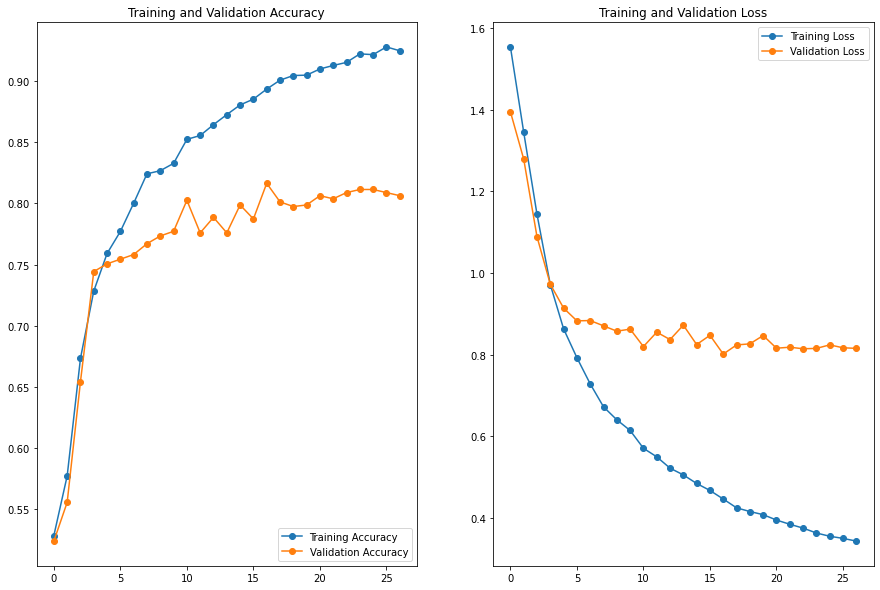

In [51]:
acc = history_da.history['accuracy']
val_acc = history_da.history['val_accuracy']

loss = history_da.history['loss']
val_loss = history_da.history['val_loss']

epochs_range = range(len(loss))

plot_model_loss_acc(epochs_range=epochs_range, acc=acc, val_acc=val_acc, loss=loss, val_loss=val_loss) 

 2/13 [===>..........................] - ETA: 1s

2022-07-02 13:23:54.624800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 1s 111ms/step


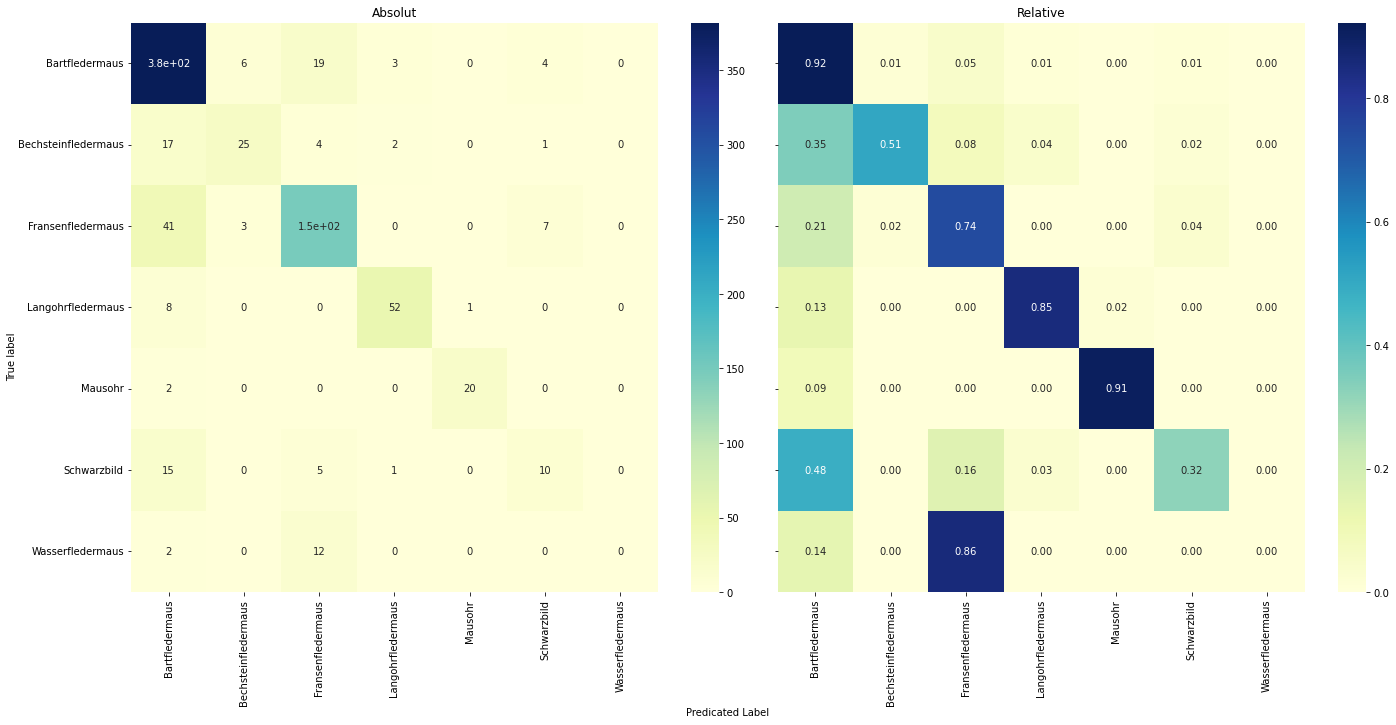

In [52]:
y_pred = model_da.predict(val_ds)
y_true = np.concatenate([y for x, y in val_ds], axis=0)

cm = confusion_matrix(y_true=np.argmax(y_true, axis=-1), y_pred=np.argmax(y_pred, axis=-1))
    
plot_confusion_matrix(cm=cm, classes=class_names)

## Keras Parameter Tuning

In [225]:
def model_builder(hp):
    model_to_train = keras.Sequential([
      layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
      layers.Conv2D(32,                      
                      kernel_size=(3,3),         
                      strides=(1,1),            
                      padding='same',            
                      activation='relu'),
      layers.MaxPooling2D(),

      layers.Conv2D(64,                      
                      kernel_size=(3,3),         
                      strides=(1,1),            
                      padding='same',            
                      activation='relu'),
      layers.MaxPooling2D(),

      layers.Conv2D(128,                      
                      kernel_size=(3,3),         
                      strides=(1,1),            
                      padding='same',            
                      activation='relu'),
      layers.MaxPooling2D(),

      layers.Flatten(),
      layers.Dropout(0.05)
    ])
  
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32) 
    model_to_train.add(keras.layers.Dense(units=hp_units, kernel_regularizer=keras.regularizers.l2(0.001), 
               bias_regularizer=keras.regularizers.l2(0.001), activation='relu'))
    model_to_train.add(keras.layers.Dense(len(class_names), activation='softmax'))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    # hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model_to_train.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    
    return model

In [226]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=20,
                     factor=3,
                     directory='my_dir',
                     project_name='bats_opti')

In [227]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [228]:
tuner.search(x=train_ds, epochs=25, validation_data=val_ds, callbacks=[stop_early, scheduler])

Trial 17 Complete [00h 01m 13s]
val_accuracy: 0.7485030293464661

Best val_accuracy So Far: 0.7694610953330994
Total elapsed time: 00h 08m 44s

Search: Running Trial #18

Value             |Best Value So Far |Hyperparameter
320               |192               |units
20                |3                 |tuner/epochs
7                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
2                 |0                 |tuner/round
0014              |None              |tuner/trial_id

Epoch 8/20


2022-06-21 11:04:44.749608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - ETA: 0s - loss: 0.1445 - accuracy: 0.9843

2022-06-21 11:04:51.910582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 9s 411ms/step - loss: 0.1445 - accuracy: 0.9843 - val_loss: 1.6917 - val_accuracy: 0.6737 - lr: 4.9659e-05
Epoch 9/20
21/21 [==============================] - 9s 418ms/step - loss: 0.1222 - accuracy: 0.9940 - val_loss: 1.6032 - val_accuracy: 0.7485 - lr: 4.4933e-05
Epoch 10/20
21/21 [==============================] - 9s 417ms/step - loss: 0.1073 - accuracy: 0.9985 - val_loss: 1.6502 - val_accuracy: 0.7545 - lr: 4.0657e-05
Epoch 11/20
21/21 [==============================] - 8s 365ms/step - loss: 0.0990 - accuracy: 1.0000 - val_loss: 1.6213 - val_accuracy: 0.7515 - lr: 3.6788e-05
Epoch 12/20
21/21 [==============================] - 8s 375ms/step - loss: 0.0954 - accuracy: 1.0000 - val_loss: 1.5911 - val_accuracy: 0.7395 - lr: 3.3287e-05
Epoch 13/20
21/21 [==============================] - 9s 431ms/step - loss: 0.0941 - accuracy: 1.0000 - val_loss: 1.6106 - val_accuracy: 0.7455 - lr: 3.0119e-05
Epoch 14/20
11/21 [==============>...............] - 

KeyboardInterrupt: 

Get the optimal hyperparameters

In [78]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 160 and the optimal learning rate for the optimizer
is 0.0001.



Build the model with the optimal hyperparameters and train it on the data for 50 epochs

In [84]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(x=train_ds, validation_data=val_ds, epochs=50)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50


2022-06-15 20:09:56.860151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - ETA: 0s - loss: 1.8917 - accuracy: 0.3830

2022-06-15 20:10:07.546438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 13s 821ms/step - loss: 1.8917 - accuracy: 0.3830 - val_loss: 1.6384 - val_accuracy: 0.4378
Epoch 2/50
14/14 [==============================] - 11s 740ms/step - loss: 1.6051 - accuracy: 0.4759 - val_loss: 1.5898 - val_accuracy: 0.4332
Epoch 3/50
14/14 [==============================] - 11s 761ms/step - loss: 1.5415 - accuracy: 0.4759 - val_loss: 1.5402 - val_accuracy: 0.4378
Epoch 4/50
14/14 [==============================] - 10s 710ms/step - loss: 1.4980 - accuracy: 0.4828 - val_loss: 1.5466 - val_accuracy: 0.4608
Epoch 5/50
14/14 [==============================] - 10s 733ms/step - loss: 1.4608 - accuracy: 0.4954 - val_loss: 1.4943 - val_accuracy: 0.4516
Epoch 6/50
14/14 [==============================] - 10s 727ms/step - loss: 1.4089 - accuracy: 0.5126 - val_loss: 1.4700 - val_accuracy: 0.4608
Epoch 7/50
14/14 [==============================] - 11s 741ms/step - loss: 1.3965 - accuracy: 0.5080 - val_loss: 1.4576 - val_accuracy: 0.5115
Epoch 8/50